# Linear and non-linear fitting in Python

## The Theis equation
The _drawdown_ or change in hydraulic head, $s$ (a measure of the water pressure above some geodetic datum) a distance $r$ from a well at time $t$ from which water is being pumped at a constant rate, $Q$, can be modelled using the _Theis_ equation,
$$
s(r, t) = H_0 - H(r,t) = \frac{Q}{4\pi T}W(u), \quad \mathrm{where}\quad u = \frac{r^2S}{4Tt}.
$$
Here $H_0$ is the hydraulic head in the absence of the well, $S$ is the aquifer storage coefficient (volume of water released per unit decrease in $H$ per unit area) and $T$ is the transmissivity (a measure of how much water is transported horizontally per unit time). The _Well Function_, $W(u)$ is simply the exponential integral, $E_1(u).$

In practice, it is often more convenient to use an approximation to the exponential integral: $W(u) \approx -\gamma - \ln u$ where $\gamma=0.577215664\cdots$ is the Euler-Mascheroni constant. This results in an expression for $s(r,t)$ known as the Jacob equation:
$$
s(r,t) = -\frac{Q}{4\pi T}\left(\gamma + \ln u \right).
$$


The following code uses `scipy.special.exp1` to calculate the full Theis equation, returning $s(r,t)$ for parameters $Q$, $S$ and $T$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import exp1

def calc_u(r, S, T, t):
    """Calculate and return the dimensionless time parameter, u."""

    return r**2 * S / 4 / T / t

In [2]:
def theis_drawdown(t, S, T, Q, r):
    """Calculate and return the drawdown s(r,t) for parameters S, T.

    This version uses the Theis equation, s(r,t) = Q * W(u) / (4.pi.T),
    where W(u) is the Well function for u = Sr^2 / (4Tt).
    S is the aquifer storage coefficient,
    T is the transmissivity (m2/day),
    r is the distance from the well (m), and
    Q is the pumping rate (m3/day).

    """

    u = calc_u(r, S, T, t)
    s_theis = Q/4/np.pi/T * exp1(u)
    return s_theis

Let's simulate a curve for $s(t)$ for a fixed distance from the well, $r=25\;\mathrm{m}$, and pumping rate $Q = 2000\;\mathrm{m^3/day}$ for a well with parameters $S = 0.0003$ and $T = 1000\;\mathrm{m^2/day}$. We'll add a bit of synthetic normally-distributed noise.

In [3]:
Q = 2000        # Pumping rate from well (m3/day)
r = 10          # Distance from well (m)

# Time grid, days.
t = np.array([1, 2, 4, 8, 12, 16, 20, 30, 40, 50, 60, 70, 80, 90, 100])

# Calculate some synthetic data to fit.
S, T = 0.0003, 1000
s = theis_drawdown(t, S, T, Q, r)
# Add some noise.
noise_sd = 4.e-3
s += s * noise_sd * np.random.randn(s.shape[0])

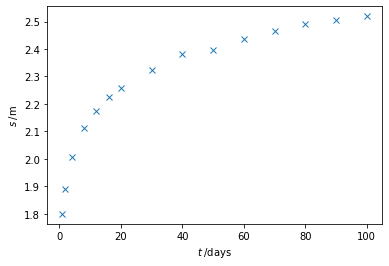

In [4]:
# Plot the data
plt.plot(t, s, 'x')
plt.xlabel(r'$t\;/\mathrm{days}$')
plt.ylabel(r'$s\;/\mathrm{m}$')
plt.show()

## Fitting the data

### Linear least squares fit

It is often the case that $s$ can be measured over time at a fixed distance from the well, $r$, for a known pumping rate $Q$, and it is required that the parameters $S$ and $T$ be found. The Theis equation is clearly non-linear in $t$, but the Jacob approximation to it can produce a straight-line plot, since:
$$
s(r,t) = -\frac{Q}{4\pi T}\left[\gamma + \ln\left(\frac{r^2S}{4T}\right)\right] + \frac{Q}{4\pi T}\ln t,
$$
So a plot of $s$ against $\ln t$ is a straight line with intercept and gradient
$$
c = -\frac{Q}{4\pi T}\left[\gamma + \ln\left(\frac{r^2S}{4T}\right)\right]
\quad \mathrm{and}\quad
m = \frac{Q}{4\pi T}
$$
whence,
$$
T = \frac{Q}{4\pi m},
\quad
S = \frac{4T}{r^2}\exp\left[-\left(\frac{c}{m}+\gamma\right)\right]
$$

The most straightforward approach is to use NumPy's [`polyfit`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.polyfit.html) routine to fit a first-order polynomial (i.e. a straight line) through the data points $(s_i, \ln t_i)$:

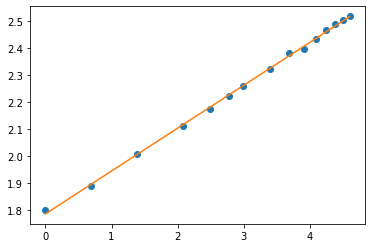

m = 0.15875900172091315, c = 1.787164979278689
rms residual = 0.025374141940541255


In [5]:
# fit s, ln(t)
lnt = np.log(t)
coeffs = np.polyfit(np.log(t), s, 1)
# plot the data and the fitted straight line
plt.plot(lnt, s, ls='', marker='o')
fit_line = np.poly1d(coeffs)(lnt)
plt.plot(lnt, fit_line)
plt.show()
# Output the fitted coefficients and report the rms residual
print('m = {}, c = {}'.format(*coeffs))
rms_residual = np.sqrt(np.sum((fit_line - s)**2))
print('rms residual =', rms_residual)

The parameters $S$ and $T$ which best fit the data are found to be as follows, and seem to agree well with the values used to create the simulated data set.

In [6]:
m, c = coeffs
def get_S_and_T(m, c):
    Tfit = Q / 4 / np.pi / m
    Sfit = 4 * Tfit / r**2 * np.exp(-(c/m + np.euler_gamma))
    return Sfit, Tfit

print('S = {}, T = {} m2/day'.format(*get_S_and_T(m,c)))

S = 0.000290781284921168, T = 1002.4939774544453 m2/day


The same analysis can be performed using [`numpy.linalg.lstsq`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.lstsq.html) which returns the sum of the square residuals along with other information about the fit:

In [13]:
A = np.vstack((lnt, np.ones_like(t))).T
x, sq_resid, rank, sing_vals = np.linalg.lstsq(A, s, rcond=None)
m, c = x
print('S = {}, T = {} m2/day'.format(*get_S_and_T(m,c)))
print('rms residual =', np.sqrt(sq_resid[0]))

S = 0.0002907812849211719, T = 1002.4939774544445 m2/day
rms residual = 0.025374141940541543


### Nonlinear least squares fit

The full Theis equation can only be fit with a nonlinear routine such as [`scipy.optimize.curve_fit`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.curve_fit.html) or [`scipy.optimize import leastsq`](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.optimize.leastsq.html). `curve_fit` can fit a function directly; it calls `leastsq` which minimizes the sum of squares of a set of equations: in this context, the residuals between the observed data and modelled $s(t)$.

#### `curve_fit`

`curve_fit` does not need an initial guess for the fit parameters (it sets them equal to 1 if none is provided, which may or may not be appropriate depending on the function). The function to be fit must take the independent variable as its first argument (here, $t$) and the parameters to be fit as the remaining arguments. Since we don't want to fit $Q$ and $r$, we'll define a wrapper function to pick them up in global scope and send them to `theis_drawdown` which requires them.

In [8]:
from scipy.optimize import curve_fit

def theis_func(t, S, T):
    return theis_drawdown(t, S, T, Q, r)

popt, pcov = curve_fit(theis_func, t, s)
Sfit, Tfit = popt
print('S = {}, T = {} m2/day'.format(Sfit, Tfit))
theis_fit = theis_drawdown(t, Sfit, Tfit, Q, r)
rms_resid = np.sqrt(np.sum((s - theis_fit)**2))
print('rms residual =', rms_resid)

S = 0.00029078683756120807, T = 1002.4926179727851 m2/day
rms residual = 0.025373753456071724


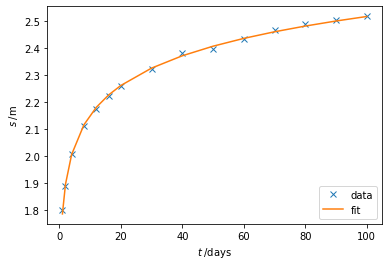

In [9]:
plt.plot(t, s, 'x', label='data')
plt.plot(t, theis_fit, label='fit')
plt.xlabel(r'$t\;/\mathrm{days}$')
plt.ylabel(r'$s\;/\mathrm{m}$')
plt.legend(loc=4)
plt.show()

#### `leastsq`

`leastsq` requires an initial guess for the fit parameters but allows additional arguments (beyond the fit parameters) to be passed to the objective function. However, it requires a function to calculate the residuals: the difference between the "observed" and "modelled" data points:

In [10]:
from scipy.optimize import leastsq

def theis_resid(p, t, s, Q, r):
    """Calculate the residual between observed and calculated drawdown s(t).

    This version uses the exact Theis equation.
    The parameters S, T are packed into the tuple p.

    """

    S, T = p
    return s - theis_drawdown(t, S, T, Q, r)


Both `leastsq` and `curve_fit` can be provided with the Jacobian: a vector of the first derivatives of the model function with respect to each of the fit parameters. In the case of the Theis function, these can be calculated analytically:
$$
\frac{\mathrm{d}s(r,t)}{\mathrm{d}S} = -\frac{Q}{4\pi T S}e^{-u}
\quad \mathrm{and} \quad
\frac{\mathrm{d}s(r,t)}{\mathrm{d}T} = \frac{Q}{4\pi T^2}\left[-W(u) + e^{-u}\right]
$$

In [11]:
def theis_Dfun(p, t, s, Q, r):
    """Calculate and return ds/dS and ds/dT for the Theis equation.

    The parameters S, T are packed into the tuple p.

    """

    S, T = p
    u = calc_u(r, S, T, t)
    dsdS = -Q / 4 / np.pi / T / S * np.exp(-u)
    dsdT = Q / 4 / np.pi / T**2 * (-exp1(u) + np.exp(-u))
    return np.array((-dsdS, -dsdT)).T


In [12]:
p0 = 0.01, 1500
popt, flag = leastsq(theis_resid, p0, Dfun=theis_Dfun, args=(t, s, Q, r))
Sfit, Tfit = popt
print('S = {}, T = {} m2/day'.format(Sfit, Tfit))
theis_fit = theis_drawdown(t, Sfit, Tfit, Q, r)
rms_resid = np.sqrt(np.sum((s - theis_fit)**2))
print('rms residual =', rms_resid)

S = 0.00029078685935237655, T = 1002.4926123788246 m2/day
rms residual = 0.02537375345607106
